In [1]:
import numpy as np
import networkx
from scipy import linalg, sparse
import sklearn
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
p=50

## Define Functions

In [2]:
def MCC(omega_true, omega_hat, p):
    
    #Get off-diagonal entries
    omega_true = omega_true[np.tril_indices(p,-1)]
    omega_hat = omega_hat[np.tril_indices(p,-1)]
    
    #MCC
    TP = np.sum((omega_true!=0.) & (omega_hat!=0.))
    FN = np.sum((omega_true!=0.) & (omega_hat==0.))
    FP = np.sum((omega_true==0.) & (omega_hat!=0.))
    TN = np.sum((omega_true==0.) & (omega_hat==0.))
    MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return MCC

## Create Precision matrix

In [3]:
#Create Omega
np.random.seed(1)
#edge probability 0.1 and p = 50
ER_graph = networkx.to_numpy_matrix(networkx.gnp_random_graph(n=p, p=0.1))

edge_weights = np.random.uniform(low=0.5, high=1., size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))

Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(ER_graph, Omega)
#Positive Definite procedure
for i in range(p):
    Omega[i,i] = 1
    off_sum = np.sum(np.abs(Omega[i,:i])) + np.sum(np.abs(Omega[i,i+1:]))
    Omega[i,:i] = Omega[i,:i]/(1.5*off_sum)
    Omega[i,i+1:] = Omega[i,i+1:]/(1.5*off_sum)
#Average for Symmetry
Omega = (Omega + Omega.T)/2
Sigma = np.linalg.inv(Omega)

## Generate Data

In [4]:
n_list = [500, 1000, 2000]
n_datasets = 10
def generate_data(n):
    prng = np.random.RandomState(1)
    data = prng.multivariate_normal(np.zeros(p), Sigma, size=(n_datasets,n))
    return data
data_list = []
for n in n_list:
    data_list.append(generate_data(n))

## Graphical Lasso CV with Sklearn

In [5]:
lambda_cv = np.zeros((3,n_datasets))
mcc_cv = np.zeros((3,n_datasets))
omega_cv = []
for j in range (3):
    for i in range(n_datasets):
        #Fit model
        model = GraphicalLassoCV().fit(data_list[j][i])
        #Add lambda
        lambda_cv[j,i] = model.alpha_
        omega_hat = model.precision_
        omega_cv.append(omega_hat)
        mcc = MCC(Omega, omega_hat, p)
        mcc_cv[j,i] = mcc

## Robust Selection

In [6]:
from robsel import *
lambda_robsel = np.zeros((3,n_datasets))
mcc_robsel = np.zeros((3,n_datasets))
omega_robsel = []
#alpha = 0.9 for Figure 2
for j in range (3):
    for i in range(n_datasets):
        lambd = RobustSelection(data_list[j][i], B=200, alpha=0.9)
        lambda_robsel[j,i] = lambd

        #Fit Graphical Lasso with RobSel lambda
        model = GraphicalLasso(alpha=lambd).fit(data_list[j][i])
        omega_hat = model.precision_
        omega_robsel.append(omega_hat)
        mcc = MCC(Omega, omega_hat, p)
        mcc_robsel[j,i] = mcc

## Matthews correlation coefficient

In [7]:
data1 = pd.DataFrame(lambda_cv.flatten(),columns=["lambd"])
data1["type"] = np.full(n_datasets*3, "CV")
data1["n"] = pd.Series(n_datasets*["n=500"] + n_datasets*["n=1000"] + n_datasets*["n=2000"]).astype('category')
data1["mcc"] = mcc_cv.flatten()

data2 = pd.DataFrame(lambda_robsel.flatten(),columns=["lambd"])
data2["type"] = np.full(n_datasets*3, "RS")
data2["n"] = pd.Series(n_datasets*["n=500"] + n_datasets*["n=1000"] + n_datasets*["n=2000"]).astype('category')
data2["mcc"] = mcc_robsel.flatten()

data = pd.concat([data1, data2], ignore_index=True)

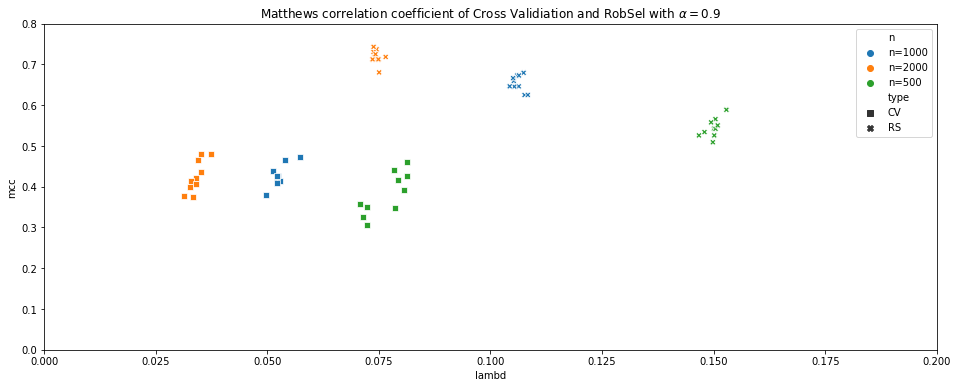

In [8]:
plt.figure(figsize=(16, 6))
markers = {"CV": "s", "RS": "X"}
ax = sns.scatterplot(x="lambd",y='mcc', hue="n", style="type", markers=markers, data=data)
ax.set_ylim(0,.8)
ax.set_xlim(0.,0.2)
plt.title(r"Matthews correlation coefficient of Cross Validiation and RobSel with $\alpha=0.9$");

(0, 0.2)

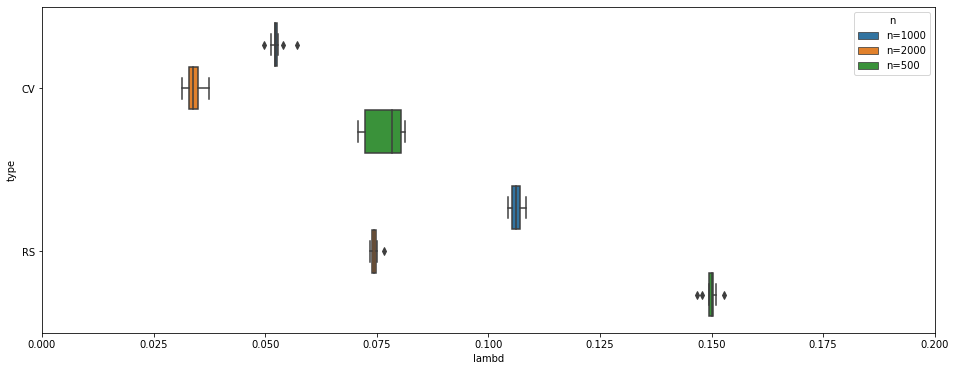

In [9]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=data["lambd"], y=data["type"],hue=data["n"],orient="h")
ax.set_xlim(0,0.2)

## Graph Visualization

### n=500

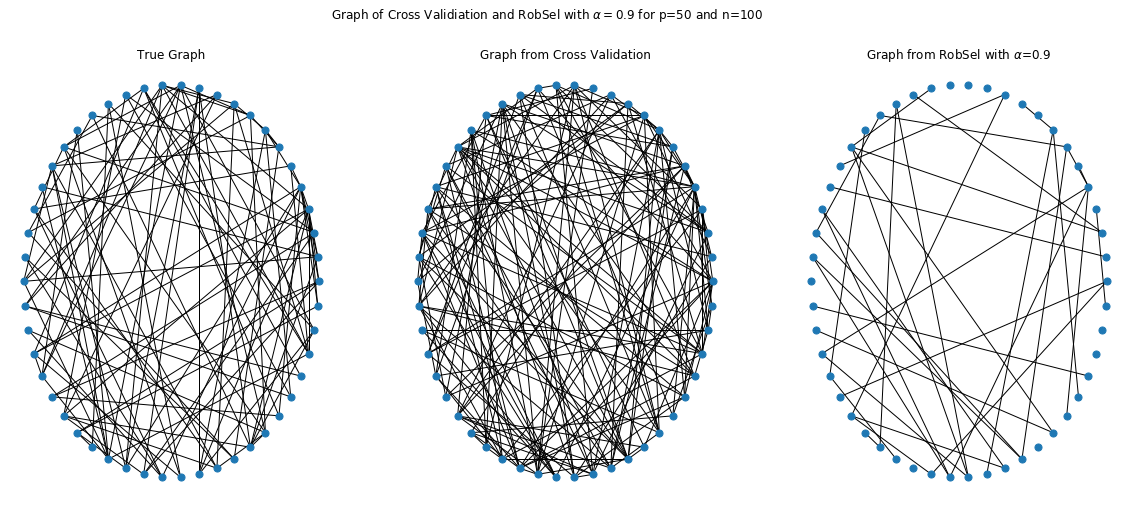

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(Omega), node_size=50, ax=axes[0])
axes[0].set_title("True Graph")
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(omega_cv[0]), node_size=50, ax=axes[1])
axes[1].set_title("Graph from Cross Validation")
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(omega_robsel[0]), node_size=50, ax=axes[2])
axes[2].set_title(r"Graph from RobSel with $\alpha$=0.9")
fig.suptitle(r"Graph of Cross Validiation and RobSel with $\alpha=0.9$ for p=50 and n=100");

### n=2000

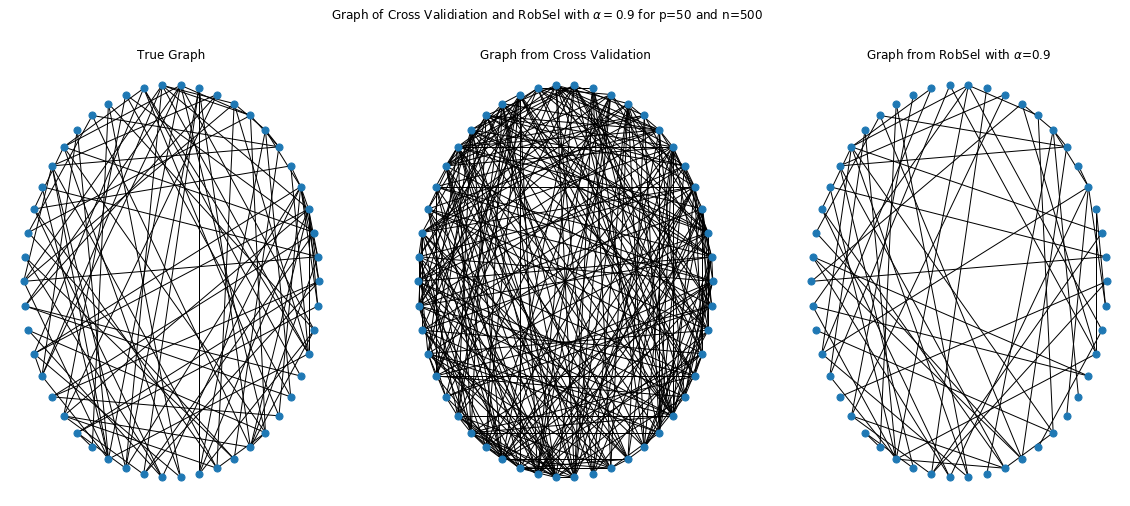

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(Omega), node_size=50, ax=axes[0])
axes[0].set_title("True Graph")
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(omega_cv[-1]), node_size=50, ax=axes[1])
axes[1].set_title("Graph from Cross Validation")
networkx.draw_circular(networkx.convert_matrix.from_numpy_array(omega_robsel[-1]), node_size=50, ax=axes[2])
axes[2].set_title(r"Graph from RobSel with $\alpha$=0.9")
fig.suptitle(r"Graph of Cross Validiation and RobSel with $\alpha=0.9$ for p=50 and n=500");